In [1]:
from pythtb import TBModel, WFArray, Mesh
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# define lattice vectors
lat = [[1.0, 0.0], [0.5, np.sqrt(3.0) / 2.0]]
# define coordinates of orbitals
orb = [[1.0 / 3.0, 1.0 / 3.0], [2.0 / 3.0, 2.0 / 3.0]]

# make two dimensional tight-binding graphene model
my_model = TBModel(2, 2, lat, orb)

# set model parameters
delta = -0.1  # small staggered onsite term
t = -1.0

# set on-site energies
my_model.set_onsite([-delta, delta])
# set hoppings (amplitude, i, j, [lattice vector to cell containing j])
my_model.set_hop(t, 0, 1, [0, 0])
my_model.set_hop(t, 1, 0, [1, 0])
my_model.set_hop(t, 1, 0, [0, 1])

print(my_model)

----------------------------------------
       Tight-binding model report       
----------------------------------------
r-space dimension           = 2
k-space dimension           = 2
number of spin components   = 1
periodic directions         = [0, 1]
number of orbitals          = 2
number of electronic states = 2

Lattice vectors (Cartesian):
  # 0 ===> [ 1.000 ,    0   ]
  # 1 ===> [ 0.500 ,  0.866 ]
Orbital vectors (dimensionless):
  # 0 ===> [ 0.333 ,  0.333 ]
  # 1 ===> [ 0.667 ,  0.667 ]
Site energies:
  # 0 ===>  0.100 
  # 1 ===> -0.100 
Hoppings:
  < 0 | H | 1 + [ 0.0 ,  0.0 ] >  ===> -1.0000
  < 1 | H | 0 + [ 1.0 ,  0.0 ] >  ===> -1.0000
  < 1 | H | 0 + [ 0.0 ,  1.0 ] >  ===> -1.0000
Hopping distances:
  | pos(0) - pos(1 + [ 0.0 ,  0.0 ]) | =  0.577 
  | pos(1) - pos(0 + [ 1.0 ,  0.0 ]) | =  0.577 
  | pos(1) - pos(0 + [ 0.0 ,  1.0 ]) | =  0.577 


In [3]:
circ_step = 31 # number of steps in the circular path
circ_center = np.array([1/3, 2/3]) # the K point
circ_radius = 0.1 # the radius of the circular path

# construct k-point coordinate on the path
kpts = []
for i in range(circ_step):
    ang = 2*np.pi * i / (circ_step - 1)
    kpt = np.array([np.cos(ang) * circ_radius, np.sin(ang) * circ_radius])
    kpt += circ_center
    kpts.append(kpt)

In [4]:
mesh = Mesh(my_model)
mesh.build_path(nodes_k=kpts, n_interp=1)

In [5]:
w_circ = WFArray(my_model, mesh)

In [6]:
w_circ.solve_k_mesh()

In [7]:
berry_phase_0 = w_circ.berry_phase([0])
berry_phase_1 = w_circ.berry_phase([1])
berry_phase_both = w_circ.berry_phase([0, 1])

print(f"Berry phase along circle with radius {circ_radius} and centered at k-point {circ_center}")
print(f"for band 0 equals    : {berry_phase_0}")
print(f"for band 1 equals    : {berry_phase_1}")
print(f"for both bands equals: {berry_phase_both}")

Berry phase along circle with radius 0.1 and centered at k-point [0.33333333 0.66666667]
for band 0 equals    : [2.56368315]
for band 1 equals    : [-2.56368315]
for both bands equals: [2.35922393e-16]


In [8]:
square_step = 31
square_center = np.array([1/3, 2/3])
square_length = 0.1

all_kpt = np.zeros((square_step, square_step, 2))
for i in range(square_step):
    for j in range(square_step):
        kpt = np.array(
            [
                square_length * (-0.5 + i / (square_step - 1)),
                square_length * (-0.5 + j / (square_step - 1)),
            ]
        )
        kpt += square_center
        all_kpt[i, j, :] = kpt

In [9]:
mesh = Mesh(my_model)
# mesh.build_grid(shape_k=(square_step, square_step), points=all_kpt)
mesh.build_custom(points=all_kpt, axis_types=['k', 'k']) 

In [10]:
w_square = WFArray(my_model, mesh)
w_square.solve_k_mesh()

In [11]:
b_flux_0 = w_square.berry_flux([0], plane=(0, 1))
b_flux_1 = w_square.berry_flux([1], plane=(0, 1))
b_flux_both = w_square.berry_flux([0, 1], plane=(0, 1))

print(f"Berry flux on square patch with length: {square_length} and centered at k-point: {square_center}")
print("for band 0 equals    : ", np.sum(b_flux_0))
print("for band 1 equals    : ", np.sum(b_flux_1))
print("for both bands equals: ", np.sum(b_flux_both))

Berry flux on square patch with length: 0.1 and centered at k-point: [0.33333333 0.66666667]
for band 0 equals    :  2.179216480131516
for band 1 equals    :  -2.1792164801315166
for both bands equals:  -6.363418570741153e-16


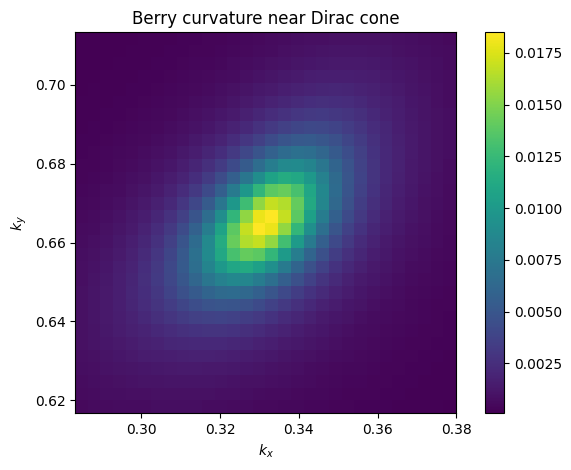

In [12]:
fig, ax = plt.subplots()
img = ax.imshow(
    b_flux_0.T.real,
    origin="lower",
    extent=(
        all_kpt[0, 0, 0],
        all_kpt[-2, 0, 0],
        all_kpt[0, 0, 1],
        all_kpt[0, -2, 1],
    ),
)
ax.set_title("Berry curvature near Dirac cone")
ax.set_xlabel(r"$k_x$")
ax.set_ylabel(r"$k_y$")
plt.colorbar(img)
fig.tight_layout()